In [72]:
from utils.plot import plot_metrics

In [74]:
df_ssim = pd.read_csv("/home/ubuntu/project/sentinel-2-ai-processor/src/logs/metrics/ssim_metrics.csv")
df_sam = pd.read_csv("/home/ubuntu/project/sentinel-2-ai-processor/src/logs/metrics/sam_metrics.csv")
df_rmse = pd.read_csv("/home/ubuntu/project/sentinel-2-ai-processor/src/logs/metrics/rmse_metrics.csv")
df_psnr = pd.read_csv("/home/ubuntu/project/sentinel-2-ai-processor/src/logs/metrics/psnr_metrics.csv")

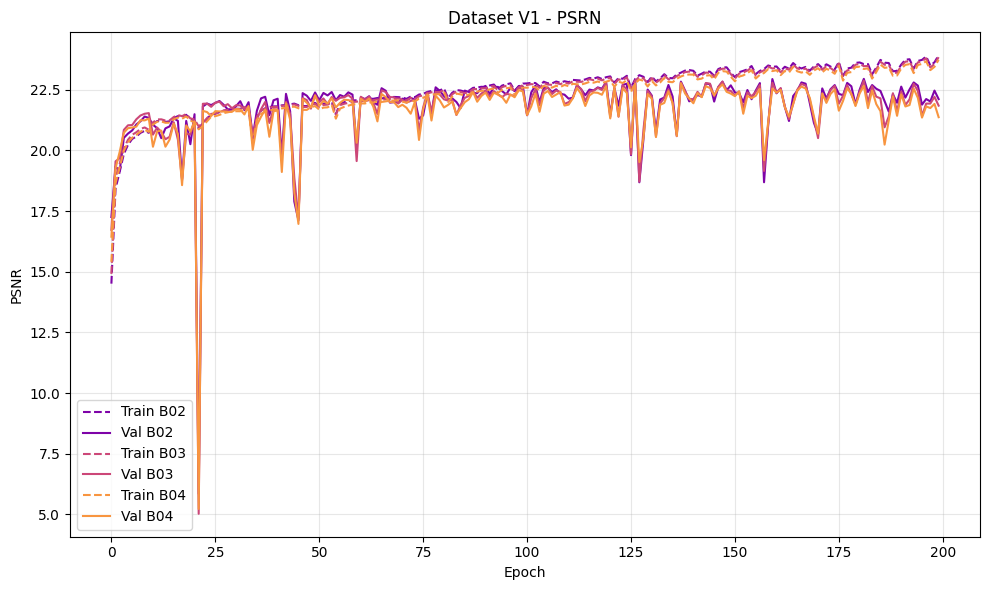

In [71]:
bands = ['B02', 'B03', 'B04']
plot_metrics(df_psnr, bands=bands, title="Dataset V1 - PSRN",
             log_scale=False,
             y_label="PSNR",
             verbose=True,
             save=False,
             save_path="ssim_metrics_plot.svg",
             color_palette="plasma")

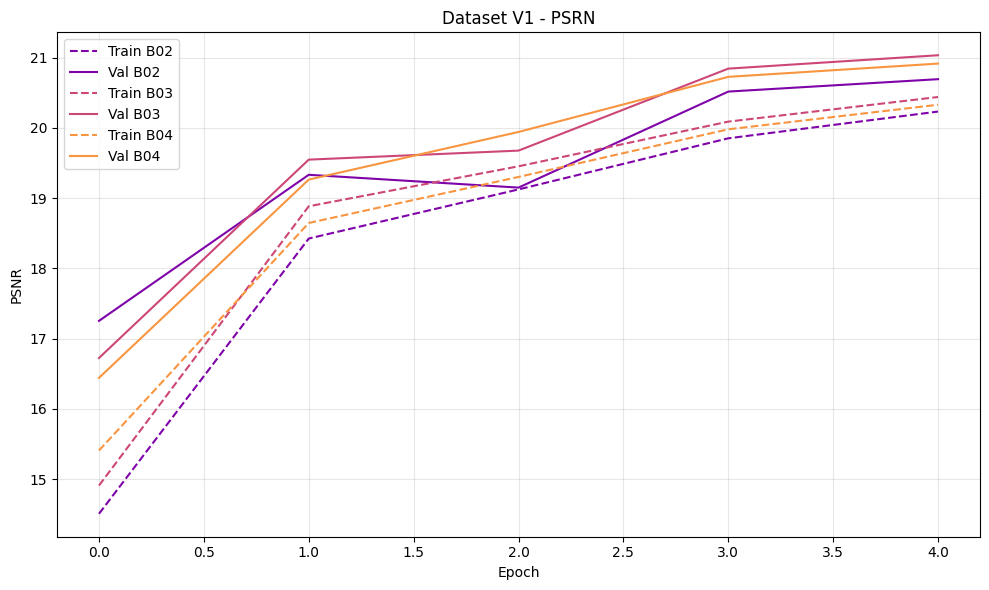

In [75]:
bands = ['B02', 'B03', 'B04']
plot_metrics(df_psnr, bands=bands, title="Dataset V1 - PSRN",
             log_scale=False,
             y_label="PSNR",
             verbose=True,
             save=False,
             save_path="ssim_metrics_plot.svg",
             color_palette="plasma")